# Algorithmic Trading - Optimizing strategy on back-testing using python

This article will be used to learn about optimizing back-testing trading strategies in python

We will first import all the necessary libraries.

In [2]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import yfinance as yf
import datetime as dt
import matplotlib.pyplot as plt
import pyfolio as pf

## 2. Financial Data Class

Now we will be creating a Financial Data Class which serves as the base class that can be inherited by any other strategy class to encapsulate all the basic functionality such as downloading data, plotting data, preparing data, and creating tear sheets.

In [18]:
class FinancialData:
    #initialize function
    def __init__(self, symbol='TSLA', end=dt.datetime.today(), days=168):
        self.symbol = symbol
        self.start = end - pd.Timedelta(days=days)
        self.end = end
        self.retrieve_data(self.symbol, self.start, self.end)
        self.prepare_data()
    
    # function call to retrieve daily data
    def retrieve_data(self, symbol, start, end):
        self.data = yf.download(symbol, start=start, end=end)
    
    # preparing data - adding daily returns and buy/hold returns column
    def prepare_data(self):
        self.data['daily_returns'] = np.log(self.data['Adj Close'] / self.data['Adj Close'].shift(1))
        self.data['bnh_returns'] = self.data['daily_returns'].cumsum()
        self.data.dropna(inplace=True)
    
    # function to plot a list of attributes in the pandas data frame
    def plot_data(self, attribute_list):
        self.data[attribute_list].plot()
        plt.show
    
    # plotting strategy returns
    def plot_strategy_returns(self):
        self.plot_data(['bnh_returns', 'strategy_returns'])
        
    # function to create a simple tear sheet using pyfolio
    def create_simple_tear_sheet(self):
        pf.display(pf.create_simple_tear_sheet(self.data['strategy_returns'].diff()))

## 3. Strategy Class

This class has:
1. Preparing Indicators
2. Backtesting the Strategy - Creating signals, positions and strategy returns
3. Optimizer - this function iterates through one or more parameters with a range of values and selects and the parameters with the highest returns. Could be further modified to sort return values in conjunction with a high Sharpe ratio as well.
4. Plot the returns of the optimized strategy.

In [21]:
class BollingerBandBacktester(FinancialData):
    def prepare_indicators(self, window):
        self.data['moving_avg'] = \
        self.data['Adj Close'].rolling(window=window).mean()
        self.data['moving_std'] = \
        self.data['Adj Close'].rolling(window=window).std()

    def backtest_strategy(self, window, start=None):
        self.prepare_indicators(window)
        self.data['upper_band'] = \
        self.data['moving_avg'] + 2 * self.data['moving_std']
        self.data['lower_band'] = \
        self.data['moving_avg'] - 2 * self.data['moving_std']

        if start is None:
            start = window

        # BUY condition
        self.data['signal'] = \
        np.where((self.data['Adj Close'] < self.data['lower_band']) &
                 (self.data['Adj Close'].shift(1) >= self.data['lower_band']), 1, 0)

        # SELL condition
        self.data['signal'] = \
        np.where((self.data['Adj Close'] > self.data['upper_band']) &
                 (self.data['Adj Close'].shift(1) <= self.data['upper_band']), -1,
                  self.data['signal'])

        self.data['position'] = self.data['signal'].replace(to_replace=0, method='ffill')
        self.data['position'] = self.data['position'].shift()

        self.data['strategy_returns'] = self.data['position'] * self.data['daily_returns']

        performance = self.data[['daily_returns', 'strategy_returns']].iloc[start:].sum()

        self.data['strategy_returns'] = self.data['strategy_returns'].cumsum()
        return performance

    def optimize_bollinger_band_parameters(self, windows):
        start = max(windows)
        self.results = pd.DataFrame()
        for window in windows:
            perf = self.backtest_strategy(window=window, start=start)
            self.result = pd.DataFrame({'Window': window,
                                        'bnh returns': perf['daily_returns'],
                                        'strategy returns': perf['strategy_returns']}, 
                                         index=[0, ])
            self.results = self.results.append(self.result, ignore_index=True)
        self.results.sort_values(by='strategy returns', inplace=True, ascending=False)
        self.results = self.results.reset_index()
        self.results = self.results.drop("index", axis=1)
        print(self.results.head())

    def plot_optimized_bollinger_strategy_returns(self):
        if (len(self.results)) > 0:
            window = self.results.loc[0, 'Window']
            print("Window:", window)
            self.backtest_strategy(window=window)
            self.plot_strategy_returns()

## 4. Create the class object and back-test

[*********************100%%**********************]  1 of 1 completed
   Window  bnh returns  strategy returns
0       8     0.434318          0.749358
1      37     0.434318          0.204992
2      36     0.434318          0.204992
3      43     0.434318          0.203040
4      46     0.434318          0.203040
Window: 8


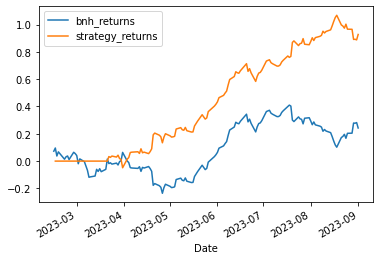

In [33]:
_symbol = "TSLA"
_end_date = dt.datetime.today()
_days = 200
Bollinger = BollingerBandBacktester(symbol=_symbol, end=_end_date, days=_days)
Bollinger.optimize_bollinger_band_parameters(range(1, 50, 1))
Bollinger.plot_optimized_bollinger_strategy_returns()

## 5. Create a tear sheet with pyfolio

Start date,2023-02-14
End date,2023-09-01
Total months,6
,Backtest
Annual return,387.974%
Cumulative returns,139.724%
Annual volatility,43.366%
Sharpe ratio,3.93
Calmar ratio,22.73
Stability,0.95
Max drawdown,-17.067%


None

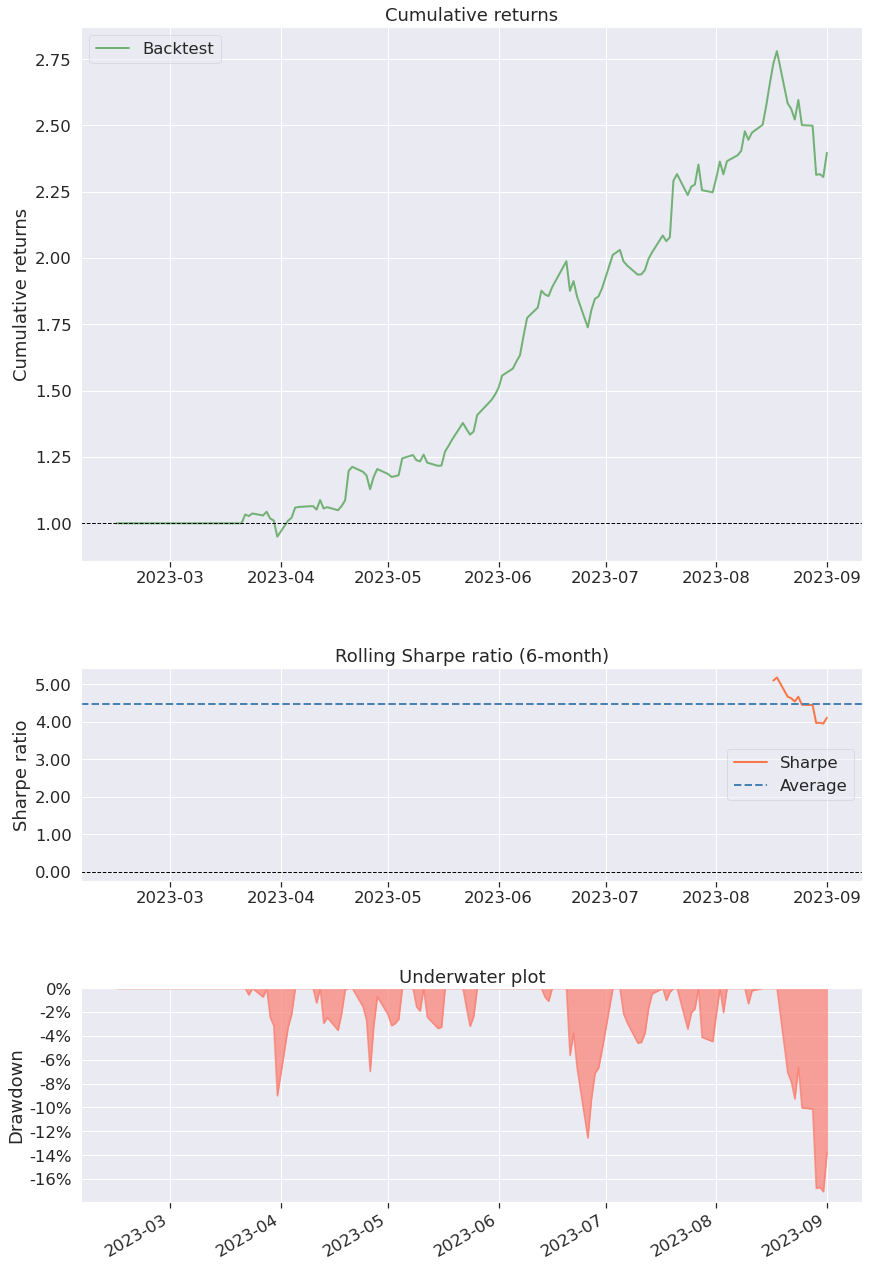

In [34]:
Bollinger.create_simple_tear_sheet()